In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/dafne/anaconda2/envs/ucl2/lib/python2.7/site-packages/matplotlib-1.5.3-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import pandas as pd
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from UKMovementSensing import hsmm
from milleniumcohort import create_config

In [4]:
config = create_config('../config.yml')
config.create_data_paths()

## Load data in database

In [5]:
config.model_path

'/media/sf_VBox_Shared/London/london_data_19Mei2017/results/mod_4st_0b_15r_720t_acceleration_anglex_angley_anglez'

In [6]:
import sqlite3
conn = sqlite3.connect(os.path.join(config.model_path, 'milleniumcohort.db'))

In [16]:
# Import data with states
filenames = os.listdir(config.states_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(config.states_path,fn))]

In [7]:
c = conn.cursor()
c.execute('drop table if exists data_with_states')
for fn in filenames:
    dataset = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
    dataset.to_sql('data_with_states', conn, if_exists='append')


In [8]:
pd.read_sql('Select * from data_with_states limit 50', conn)

,timestamp,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,...,filename,subset,switched_pos,binFile,day,slot,activity,label,start_time,state
0,2015-03-15 01:00:00,0.003614,1.000985,63.034025,-9.132411,25.136528,0.892477,-0.158931,0.425350,-0.000399,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
1,2015-03-15 01:00:05,0.003294,1.000566,63.052156,-9.046501,25.152045,0.892477,-0.157422,0.425527,-0.000299,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
2,2015-03-15 01:00:10,0.003160,1.000648,63.100261,-8.991313,25.123815,0.892477,-0.156403,0.424900,-0.000140,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
3,2015-03-15 01:00:15,0.003196,1.000557,63.006480,-9.035942,25.204352,0.892477,-0.157305,0.426527,-0.000619,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
4,2015-03-15 01:00:20,0.002897,1.000020,62.964171,-9.134642,25.209097,0.892477,-0.159068,0.426762,-0.001197,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
5,2015-03-15 01:00:25,0.003602,1.001609,63.003149,-9.009578,25.218450,0.892477,-0.156854,0.426762,-0.000279,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
6,2015-03-15 01:00:30,0.003142,1.000386,63.010738,-8.985229,25.220271,0.892477,-0.156423,0.426762,-0.001097,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
7,2015-03-15 01:00:35,0.003559,1.001118,63.088137,-9.134550,25.078780,0.892477,-0.158891,0.424233,0.000060,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
8,2015-03-15 01:00:40,0.003405,1.000644,63.114684,-9.028721,25.093715,0.892477,-0.157030,0.424370,0.000180,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2
9,2015-03-15 01:00:45,0.003709,1.001504,62.964171,-9.134642,25.209097,0.892477,-0.159068,0.426762,-0.000339,...,__021984_2015-03-19 14-10-32.bin_day2.csv,1,0,__021984_2015-03-19 14-10-32.bin,2,127,None,None,None,2


In [193]:
pd.read_sql('Select count(distinct filename), count(*) from data_with_states', conn)

,count(distinct filename),count(*)
0,1534,24278040


In [13]:
states = pd.read_sql('Select distinct state from data_with_states', conn)

In [15]:
len(states)

4

In [25]:
#Define consistent colormap
from matplotlib.colors import LinearSegmentedColormap
# One more than the number of states, so we have a color for 'All'
nr_states = len(states)
colormap, cmap = hsmm.get_color_map(nr_states+1)
cmap_states = LinearSegmentedColormap.from_list('name',
                                             [colormap[i] for i in range(nr_states)],
                                             nr_states)

In [20]:
# Load simplified activities map
activities_simplified = pd.read_csv(config.activities_simplified_path, header=0, sep=',', dtype=str, encoding='utf-8')
levelmap = {'0': "low", '1': "high", '2':"mixed"}
def get_category_des(motion, arm_changes):
    return levelmap[motion]+" motion, " + levelmap[arm_changes] + " arm changes"
activities_simplified['simplified_category'] = [get_category_des(row[1], row[2]) for row in activities_simplified.get_values()]
activities_simplified.to_sql('activities_simplified', conn)

In [12]:

heuristic_classes = ['1 - no activity',  #1
                     '2 - inactivity', #2
                     '3 - light activity', #3 
                     '4 - vigorous activity', #4
                    '5 - MVPA at least 10 min', #5
                    '6 - MVPA 1-10 min', #6
                    '7 - inactivity at least 30min'] #7 
get_heuristic = lambda i: heuristic_classes[int(i)-1]

In [39]:
pd.read_sql('pragma table_info(data_with_states)', conn)

,cid,name,type,notnull,dflt_value,pk
0,0,timestamp,TIMESTAMP,0,None,0
1,1,acceleration,REAL,0,None,0
2,2,EN,REAL,0,None,0
3,3,anglex,REAL,0,None,0
4,4,angley,REAL,0,None,0
5,5,anglez,REAL,0,None,0
6,6,roll_med_acc_x,REAL,0,None,0
7,7,roll_med_acc_y,REAL,0,None,0
8,8,roll_med_acc_z,REAL,0,None,0
9,9,dev_roll_med_acc_x,REAL,0,None,0


## Get subjects with >20 hour data

In [ ]:
all_data.columns

In [ ]:
timecounts = pd.read_sql('Select filename, count(*) from data_with_states group by filename', conn)

In [26]:
timecounts = timecounts.set_index('filename')
timecounts.columns = ['cnt_5sec']
timecounts['cnt_hours'] = timecounts['cnt_5sec'] / (12.0 * 60)

In [28]:
timecounts.to_sql('timecounts', conn)

In [30]:
longdays = timecounts[timecounts['cnt_hours']>=24].index
longdays.shape

(974,)

## Calculate per-state statistics

In [33]:
numerical_columns = ['acceleration','EN',
        'anglex','angley',u'anglez',u'roll_med_acc_x',u'roll_med_acc_y',
        u'roll_med_acc_z',u'dev_roll_med_acc_x',
             u'dev_roll_med_acc_y',u'dev_roll_med_acc_z']
query = '''Select state, ''' +  ','.join(['avg({})'.format(co) for co in numerical_columns]) + '''
from data_with_states group by state'''

avg_bystate = pd.read_sql(query, conn)

In [44]:
avg_bystate = avg_bystate.set_index('state').transpose()
avg_bystate.index = numerical_columns

In [47]:
means = avg_bystate.loc[config.hsmmconfig.column_names]
means.style.background_gradient(cmap='coolwarm',axis=1)

state,0,1,2,3
acceleration,0.00502117,0.0543667,0.00162607,0.215193
anglex,-35.123,-39.033,10.3239,1.12172
angley,18.4182,-5.89884,-6.94967,-2.16001
anglez,-32.0821,2.58269,13.0676,-2.38283


In [45]:
avg_bystate.style.background_gradient(cmap='coolwarm',axis=1)

state,0,1,2,3
acceleration,0.00502117,0.0543667,0.00162607,0.215193
EN,1.00451,1.02272,1.00045,1.17186
anglex,-35.123,-39.033,10.3239,1.12172
angley,18.4182,-5.89884,-6.94967,-2.16001
anglez,-32.0821,2.58269,13.0676,-2.38283
roll_med_acc_x,-0.509346,-0.55074,0.147485,0.00721711
roll_med_acc_y,0.278512,-0.0828738,-0.100705,-0.0180243
roll_med_acc_z,-0.472561,0.039403,0.18249,-0.0444938
dev_roll_med_acc_x,0.00100651,0.00281059,-0.00015916,-0.0134351
dev_roll_med_acc_y,8.21625e-06,0.00028339,-2.4283e-06,-0.00711908


In [52]:
#Create random sample to do calculations on
sample = pd.read_sql(
    '''select state, heuristic, acceleration, anglex, angley, anglez
        from data_with_states
        where abs(random()%1) < 0.1 
    ''', conn)

In [53]:
sample.shape

(24278040, 6)

In [54]:
sample['cut-off'] = [get_heuristic(i) for i in sample['heuristic']]

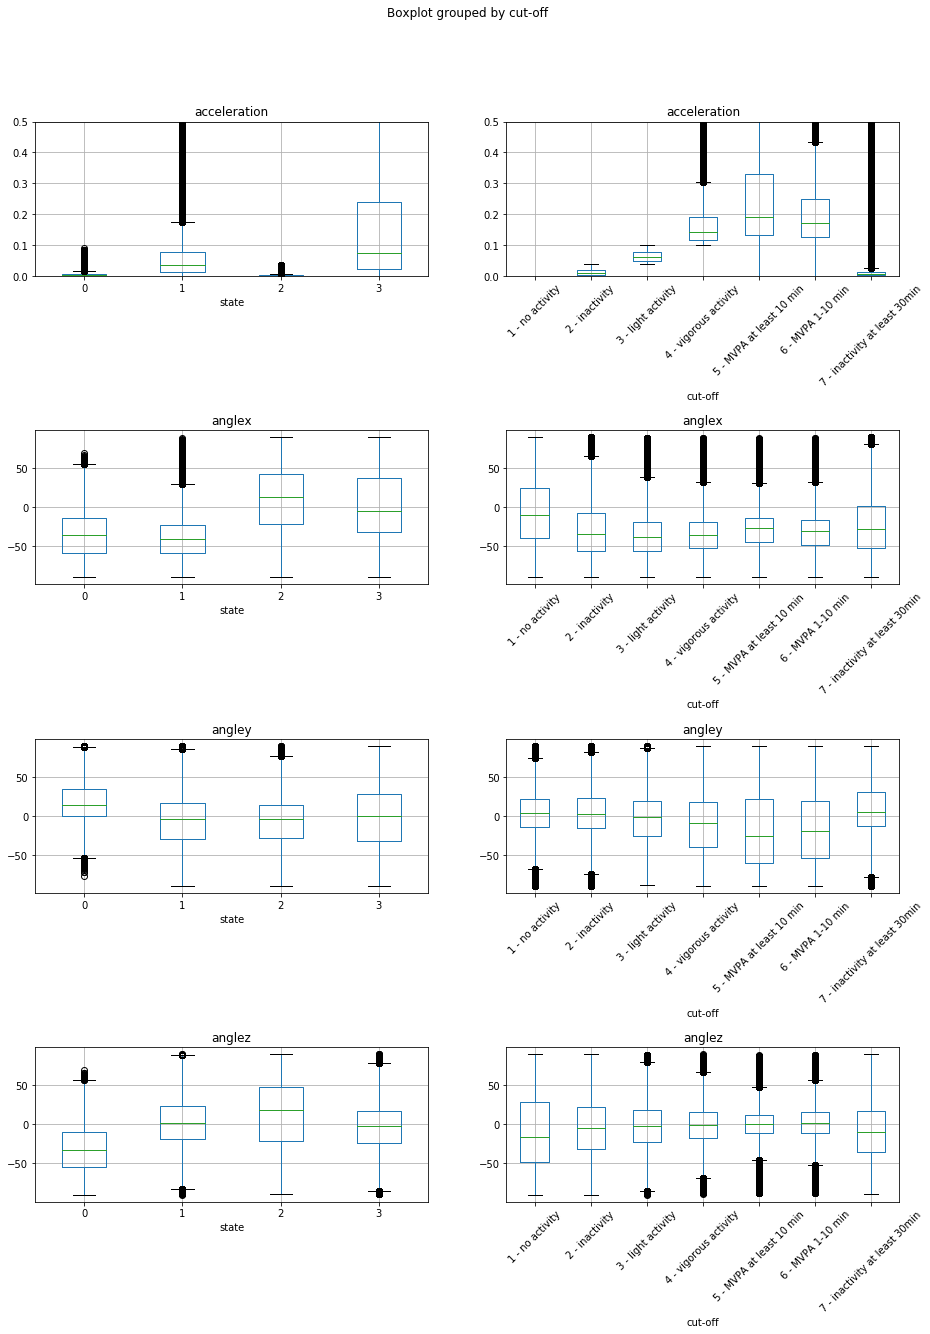

In [72]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=1)
fig.set_label('')
sample.boxplot(by='state', column=config.hsmmconfig.column_names, ax=axes[:,0])
sample.boxplot(by='cut-off', column=config.hsmmconfig.column_names, ax=axes[:, 1], rot=45)
ymax_acc = 0.5
axes[0, 0].set_ylim(0, ymax_acc)
axes[0, 1].set_ylim(0, ymax_acc)
plt.show()

## Get sojourn times

In [86]:
def sojourn_times(df, colname):
    changepoints = (df[colname].shift(1) != df[colname]) | (df.filename.shift(1) != df.filename)
    df['block'] = changepoints.astype(int).cumsum()
    sojourn_times = df.groupby([colname, 'block'])['EN'].count()
    sojourn_times = sojourn_times.reset_index()[[colname, 'EN']]
    sojourn_times.columns = [colname, 'time']
    df.drop('block', 1)
    return sojourn_times

In [87]:
sojourn_times_state = sojourn_times(all_data, 'state')
sojourn_times_cutoff = sojourn_times(all_data, 'cut-off')

In [ ]:
sojourn_times_cutoff.head()

In [ ]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 2000
sojourn_times_state.boxplot(by='state', column='time', ax=axes[0])
axes[0].set_ylim(top=ymax)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%d sec'))
axes[0].set_title('sojourn time per state')
sojourn_times_cutoff.boxplot(by='cut-off', column='time', ax=axes[1], rot=45)
axes[1].set_ylim(top=ymax)
axes[1].set_title('sojourn time per cut-off category')
plt.show()

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [73]:
ctab_long = pd.read_sql('''select label, state, count(*) from data_with_states group by label, state''', conn) 

In [78]:
ctab = ctab_long.pivot(index='label', columns='state', values='count(*)')

In [82]:
activities_simplified

,Label,"Locomotion (no=0,yes=1,unclear=2)","Frequent arm angle changes (no=0,yes=1,unclear=2)",SUM,Keep variable,Behavioural category,simplified_category
0,Sleeping and resting (including sick in bed),0,0,0,TRUE,0,"low motion, low arm changes"
1,"Did nothing, just relaxing, bored, waiting",0,0,0,TRUE,0,"low motion, low arm changes"
2,"Watch TV, DVDs, downloaded videos",0,0,0,TRUE,0,"low motion, low arm changes"
3,Eating a meal,0,1,1,TRUE,1,"low motion, high arm changes"
4,Reading (not for school),0,1,1,TRUE,1,"low motion, high arm changes"
5,"Answering emails, instant messaging, texting",0,1,1,TRUE,1,"low motion, high arm changes"
6,"Travel by physically active means (walk, bike ...",1,1,2,TRUE,2,"high motion, high arm changes"
7,"Other exercise and sports, dancing, keeping fi...",1,1,2,TRUE,2,"high motion, high arm changes"
8,"Fixing things around the house, fixing bike, g...",1,1,2,TRUE,2,"high motion, high arm changes"
9,"Team ball games and training (e.g. football, h...",1,1,2,TRUE,2,"high motion, high arm changes"


In [100]:
ctab_merged = ctab_long.merge(activities_simplified, left_on='label', right_on='Label')
ctab_simplified_long = ctab_merged.groupby(['simplified_category', 'state'])[['count(*)']].sum()
ctab_simplified = ctab_simplified_long.reset_index().pivot(index='simplified_category', columns='state', values='count(*)')

In [101]:
ctab_simplified

state,0,1,2,3
simplified_category,,,,
"high motion, high arm changes",296827,991052,151972,259649
"low motion, high arm changes",341358,559230,179736,108516
"low motion, low arm changes",3121513,1389273,3666189,453485
"low motion, mixed arm changes",1441155,2499584,626450,443171
"mixed motion, high arm changes",279169,569788,185948,107735
"mixed motion, low arm changes",51234,136322,20673,19531
"mixed motion, mixed arm changes",472860,1099401,304738,216221


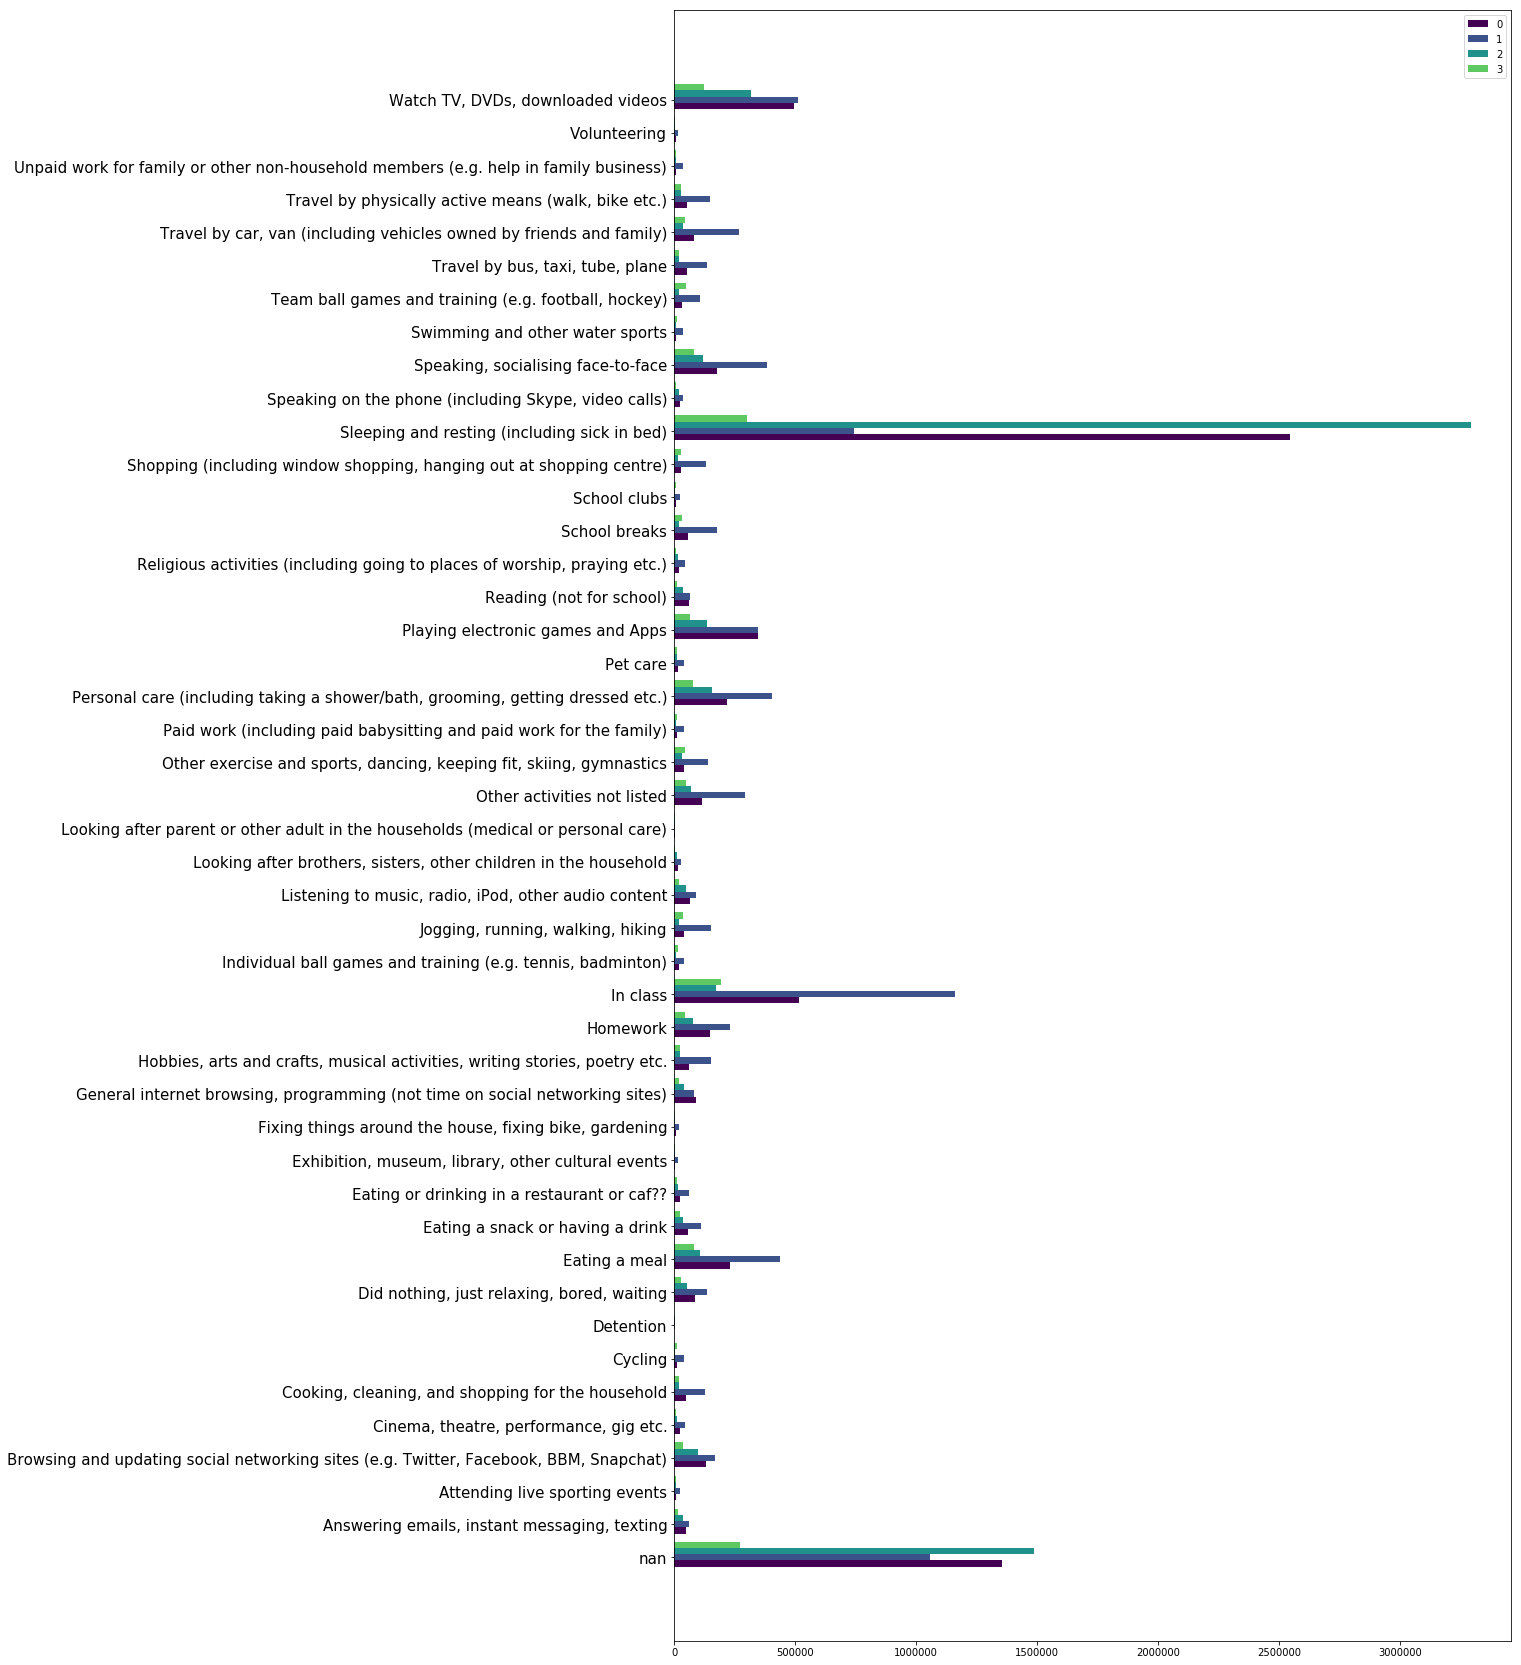

In [94]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [120]:
#Now normalize over the activity and sort by total number
ctab_norm1 = ctab_simplified.copy()
ctab_norm1.loc['All',:] = ctab_norm1.sum()
ctab_norm1 = ctab_norm1.divide(ctab_norm1.sum(axis=1), axis='index')

In [123]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

state,0,1,2,3
simplified_category,,,,
"high motion, high arm changes",0.174655,0.583143,0.0894216,0.15278
"low motion, high arm changes",0.287135,0.4704,0.151186,0.0912789
"low motion, low arm changes",0.361686,0.160973,0.424796,0.0525447
"low motion, mixed arm changes",0.287635,0.498883,0.125031,0.0884509
"mixed motion, high arm changes",0.244319,0.498659,0.162735,0.094286
"mixed motion, low arm changes",0.224947,0.598534,0.0907666,0.0857525
"mixed motion, mixed arm changes",0.225901,0.52522,0.145583,0.103296
All,0.300314,0.362363,0.256878,0.0804444


In [97]:
ctab_norm1.to_clipboard()

In [156]:
ctab_norm2 = ctab_simplified.copy()
ctab_norm2['All'] = ctab_norm2.sum(axis=1)
ctab_norm2.divide(ctab_norm2.sum(axis=0), axis='columns')

state,0,1,2,3,All
simplified_category,,,,,
"high motion, high arm changes",0.049437,0.136798,0.029591,0.161442,0.085006
"low motion, high arm changes",0.056854,0.077192,0.034997,0.067472,0.059463
"low motion, low arm changes",0.519896,0.191765,0.713863,0.281964,0.431679
"low motion, mixed arm changes",0.240028,0.345025,0.121979,0.275551,0.250608
"mixed motion, high arm changes",0.046496,0.078649,0.036207,0.066987,0.057153
"mixed motion, low arm changes",0.008533,0.018817,0.004025,0.012144,0.011392
"mixed motion, mixed arm changes",0.078756,0.151754,0.059337,0.134440,0.104699


In [157]:
#Now normalize over state and sort by total number
#ind = list(ctab.index)
ctab_norm2 = ctab_simplified.copy()
ctab_norm2['All'] = ctab_norm2.sum(axis=1)
ctab_norm2 = ctab_norm2.divide(ctab_norm2.sum(axis=0), axis='columns')

In [158]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

state,0,1,2,3,All
simplified_category,,,,,
"high motion, high arm changes",0.0494373,0.136798,0.0295913,0.161442,0.0850057
"low motion, high arm changes",0.056854,0.0771921,0.0349973,0.0674722,0.0594635
"low motion, low arm changes",0.519896,0.191765,0.713863,0.281964,0.431679
"low motion, mixed arm changes",0.240028,0.345025,0.121979,0.275551,0.250608
"mixed motion, high arm changes",0.0464963,0.0786495,0.0362069,0.0669865,0.0571526
"mixed motion, low arm changes",0.00853315,0.0188169,0.00402535,0.0121438,0.0113921
"mixed motion, mixed arm changes",0.078756,0.151754,0.0593371,0.13444,0.104699


Check if there is a significant correlation between the states and the activities:

In [162]:
ctab['All'] = ctab.sum(axis=1)
ctab = ctab.sort_values('All', ascending=False)

In [163]:
topactivities = 10 # take most frequent activities
counts = ctab.as_matrix()[1:1+topactivities,:-1]
chi2, p, dof, expected = scipy.stats.chi2_contingency(counts)

print(chi2, p)

1219617.7599 0.0


In [164]:
ctab.head(10)

state,0,1,2,3,All
label,,,,,
Sleeping and resting (including sick in bed),2544465,742201,3295868,300966,20650500
NaN,1355593,1057255,1485662,273110,12514860
In class,517013,1162151,172429,193987,6136740
"Watch TV, DVDs, downloaded videos",493285,512323,317171,124481,4341780
Playing electronic games and Apps,345175,347111,133323,64431,2670120
Eating a meal,231896,435183,107328,81793,2568600
"Personal care (including taking a shower/bath, grooming, getting dressed etc.)",217066,402266,153947,78541,2555460
"Speaking, socialising face-to-face",175713,383619,116879,80749,2270880
Other activities not listed,114737,293634,68108,49721,1578600


In [165]:
# Only easy interpreted activities
activities = ['Sleeping and resting (including sick in bed)', 'Jogging, running, walking, hiking']
ctab[[a in activities for a in ctab.index]]

state,0,1,2,3,All
label,,,,,
Sleeping and resting (including sick in bed),2544465,742201,3295868,300966,20650500
"Jogging, running, walking, hiking",41399,152040,19199,35402,744120


## Compare with heuristic

In [170]:
ctab_heuristic_long = pd.read_sql('''select heuristic, state, count(*) from data_with_states group by heuristic, state''', conn)

In [177]:
ctab_heuristic = ctab_heuristic_long.pivot(index='heuristic', columns='state', values='count(*)').fillna(0)

In [178]:
ctab_heuristic.index = [get_heuristic(i) for i in ctab_heuristic.index]

In [184]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=0), axis=1)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=0)

state,0,1,2,3
1 - no activity,0.39423,0.000286027,0.615436,0.047198
2 - inactivity,0.305941,0.423857,0.195042,0.216978
3 - light activity,0.00390872,0.254136,0,0.133958
4 - vigorous activity,0,0.105133,0,0.148082
5 - MVPA at least 10 min,1.47591e-05,0.0317274,1.79296e-05,0.142001
6 - MVPA 1-10 min,0,0.0456988,0,0.158884
7 - inactivity at least 30min,0.295906,0.139162,0.189505,0.1529


In [185]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=1), axis=0)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=1)

state,0,1,2,3
1 - no activity,0.410769,0.000337476,0.576289,0.0126044
2 - inactivity,0.300887,0.472033,0.172386,0.0546931
3 - light activity,0.0119893,0.882699,0,0.105312
4 - vigorous activity,0,0.758261,0,0.241739
5 - MVPA at least 10 min,0.000203988,0.496553,0.000222702,0.503021
6 - MVPA 1-10 min,0,0.559618,0,0.440382
7 - inactivity at least 30min,0.446325,0.237688,0.256878,0.0591092


## Heuristic vs states, per person

In [8]:
heuristic_states = pd.read_sql('''select d.filename, d.state, d.heuristic, count(*)
                from data_with_states d
                join timecounts t
                on t.filename = d.filename
                where t.cnt_hours > 20
                group by d.filename, d.state, d.heuristic;''', 
                               conn)

In [14]:
nr_subjects = len(heuristic_states['filename'].unique())
ctab = heuristic_states.groupby(['state', 'heuristic'])['count(*)'].sum()
ctab = ctab / nr_subjects
ctab = ctab.unstack(level=-1)
ctab = ctab.fillna(0)
ctab['total'] = heuristic_states.groupby(['state'])['count(*)'].sum() / nr_subjects
ctab.loc['total',] = ctab.sum(axis=0) 
ctab.applymap(lambda c: float(c)/nr_subjects)
ctab = ctab.applymap(lambda c: '{:.0f} min'.format(c/12.0))
ctab.columns = [get_heuristic(i) for i in ctab.columns[:-1]] + ['total']

In [15]:
ctab

,1 - no activity,2 - inactivity,3 - light activity,4 - vigorous activity,5 - MVPA at least 10 min,6 - MVPA 1-10 min,7 - inactivity at least 30min,total
state,,,,,,,,
0,181 min,133 min,2 min,0 min,0 min,0 min,124 min,441 min
1,0 min,204 min,122 min,50 min,15 min,22 min,66 min,479 min
2,249 min,76 min,0 min,0 min,0 min,0 min,67 min,392 min
3,5 min,23 min,14 min,16 min,15 min,17 min,16 min,107 min
total,436 min,436 min,138 min,66 min,30 min,39 min,273 min,1418 min


## Distributions for the heuristic levels

## States for an example sequence

In [37]:
example_index = 674

In [38]:
fn = filenames[example_index]
data = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
data.head()

,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,dev_roll_med_acc_y,...,filename,subset,switched_pos,binFile,day,activity,label,start_time,slot,state
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-04-14 03:45:00,0.000907,0.992121,13.719190,0.849393,76.253158,0.235546,0.014723,0.964731,0.000895,0.000463,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,2
2015-04-14 03:45:05,0.001425,0.993161,13.717265,0.667200,76.265882,0.235488,0.011564,0.964676,0.001772,0.001946,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,2
2015-04-14 03:45:10,0.001630,0.993256,13.712525,0.817176,76.261757,0.235468,0.014167,0.964906,0.001871,0.000237,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,2
2015-04-14 03:45:15,0.000901,0.991669,13.752782,0.669746,76.230277,0.235987,0.011603,0.964126,0.001275,0.001530,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,2
2015-04-14 03:45:20,0.001142,0.993087,13.727591,0.667884,76.255533,0.235720,0.011579,0.964873,0.001399,0.002274,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,2


In [39]:
hidden_states = data['state']

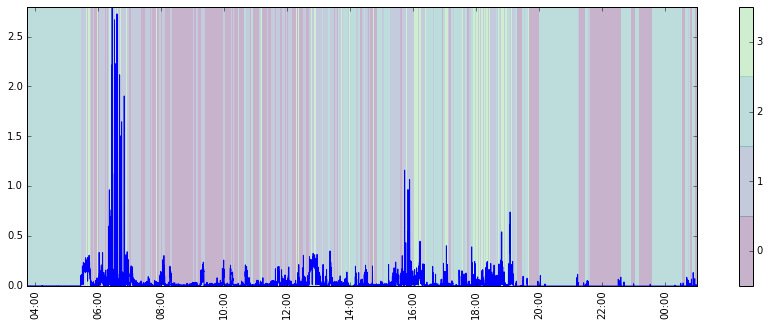

In [40]:
hsmm.plot_states_and_var(data, hidden_states, columns=['acceleration',], by='activity', cmap=cmap_states);
#plt.show()

(1440, 23)


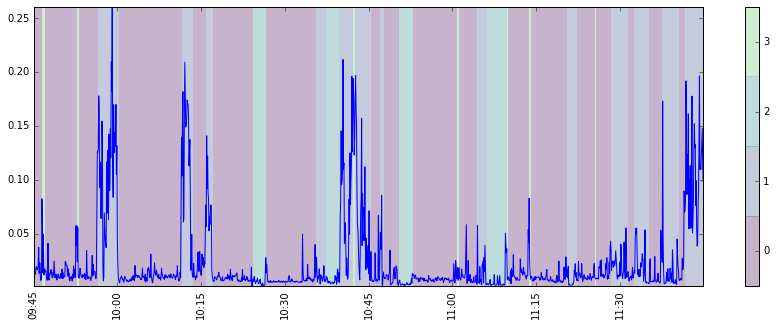

In [41]:
start =int(6*12*60)
end = 8*12*60
print(data[start:end].shape)
fig, ax = hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by=None)
ax.set_title('acceleration')

(<matplotlib.figure.Figure at 0x7f22c1864d50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22c161cdd0>)

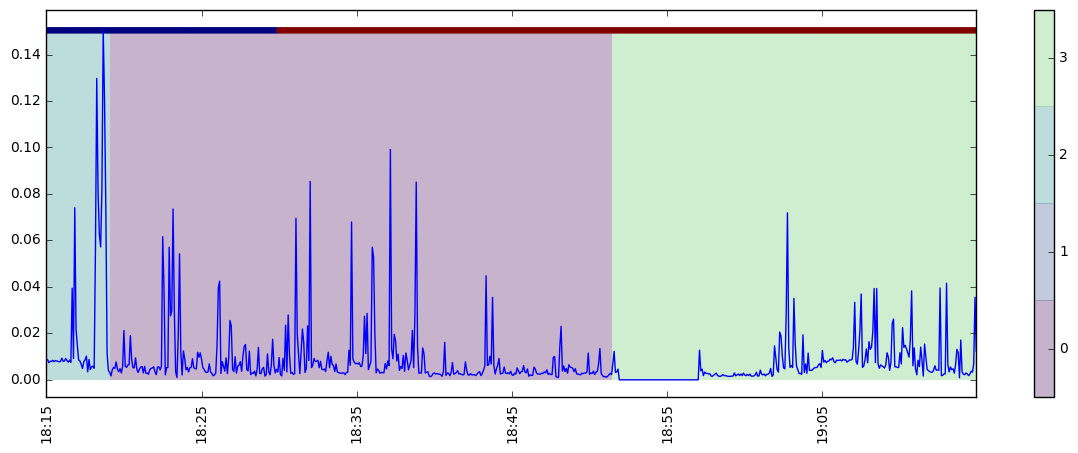

In [116]:
start =int(8*12*60)
end = 9*12*60
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by='activity')

(<matplotlib.figure.Figure at 0x7f22c16d2a50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22c170b350>)

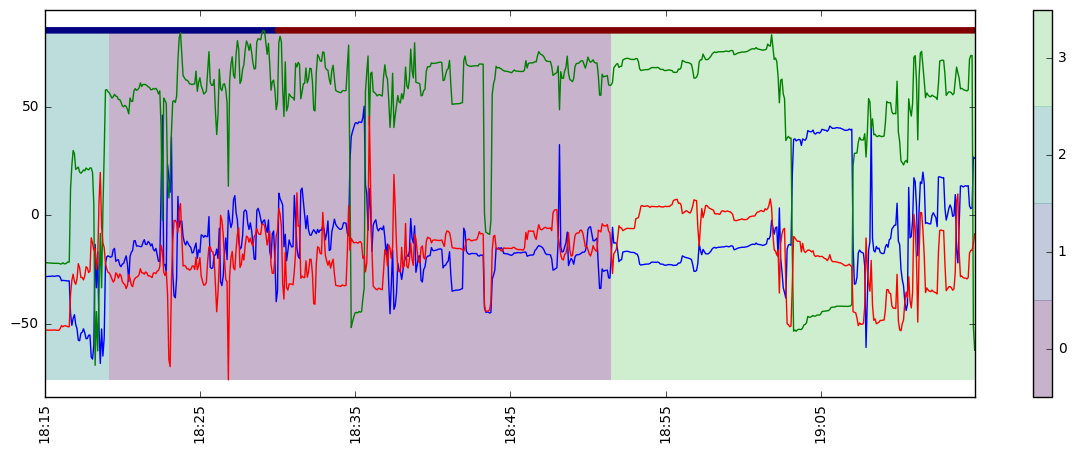

In [117]:
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], by='activity')